In [16]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data

In [21]:
users, ratings, movies = load_data('../../data/ml-1m/')

# Split data into train and test by timestamp
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['reward'] = (ratings['rating'] >= 4).astype(int)
split_point = int(len(ratings) * 0.8)
sorted_ratings = ratings.sort_values(by='timestamp')
train_ratings = sorted_ratings[:split_point].copy()
test_ratings = sorted_ratings[split_point:].copy()

arms = train_ratings['movie_id'].unique()

In [22]:
class EpsilonGreedy:
    def __init__(self, arms, epsilon):
        self.arms = arms
        self.epsilon = epsilon
        self.counts = {arm: 0 for arm in arms}
        self.values = {arm: 0.0 for arm in arms}

    def select_arm(self):
        if random.random() > self.epsilon:
            return max(self.values, key=self.values.get)
        else:
            return random.choice(self.arms)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = value + (1 / n) * (reward - value)

class UCB:
    def __init__(self, arms):
        self.arms = arms
        self.counts = {arm: 0 for arm in arms}
        self.values = {arm: 0.0 for arm in arms}
        self.total_counts = 0

    def select_arm(self):
        for arm in self.arms:
            if self.counts[arm] == 0:
                return arm
        ucb_values = {arm: self.values[arm] + np.sqrt(2 * np.log(self.total_counts) / self.counts[arm]) for arm in self.arms}
        return max(ucb_values, key=ucb_values.get)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = value + (1 / n) * (reward - value)


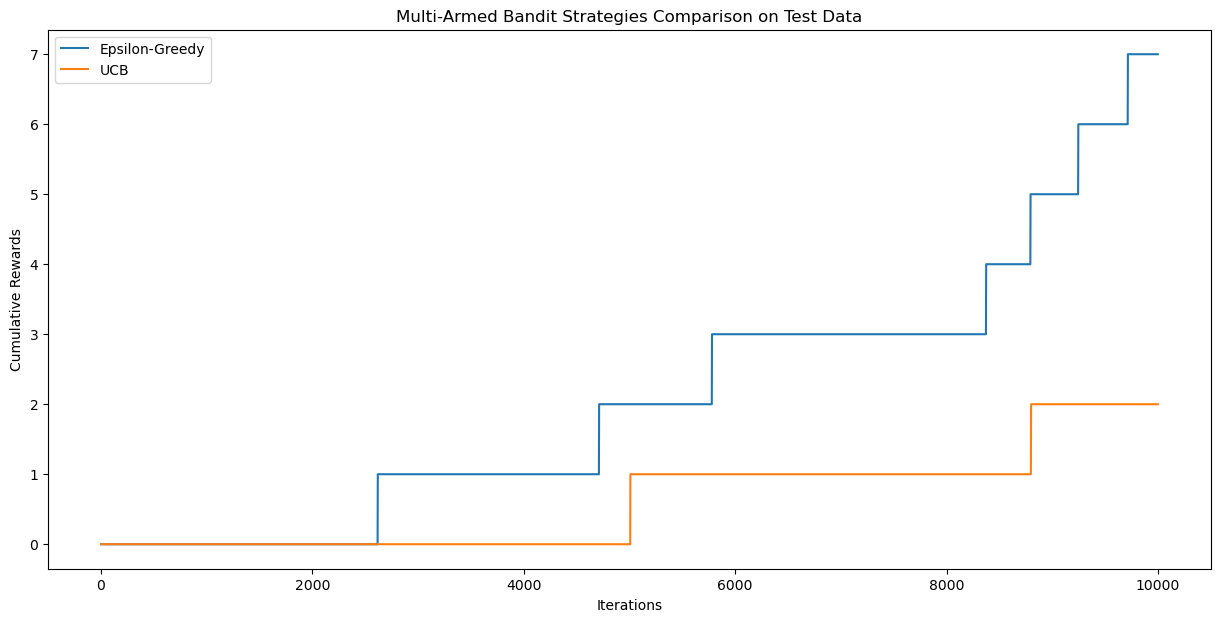

In [24]:
def train_bandit(bandit, train_data, iterations=50000):
    for _ in range(iterations):
        user_sample = train_data.sample(1).iloc[0]
        chosen_arm = bandit.select_arm()
        reward = user_sample['reward'] if user_sample['movie_id'] == chosen_arm else 0
        bandit.update(chosen_arm, reward)

def test_bandit(bandit, test_data, iterations=10000):
    rewards = []
    for _ in range(iterations):
        user_sample = test_data.sample(1).iloc[0]
        chosen_arm = bandit.select_arm()
        reward = user_sample['reward'] if user_sample['movie_id'] == chosen_arm else 0
        bandit.update(chosen_arm, reward)
        rewards.append(reward)
    return np.cumsum(rewards)

epsilon_greedy = EpsilonGreedy(arms, epsilon=0.1)
ucb = UCB(arms)

# Train 
train_bandit(epsilon_greedy, train_ratings)
train_bandit(ucb, train_ratings)

# Test 
eg_rewards = test_bandit(epsilon_greedy, test_ratings)
ucb_rewards = test_bandit(ucb, test_ratings)

plt.figure(figsize=(15, 7))
plt.plot(eg_rewards, label='Epsilon-Greedy')
plt.plot(ucb_rewards, label='UCB')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.title('Multi-Armed Bandit Strategies Comparison on Test Data')
plt.legend()
plt.show()